# Biomedical literature annotations

This {{ "[repository]({})".format(repo_url) }} stores manual annotations (a.k.a tagging, labelling) of biomedical scientific publications.
Examples of information that has been annotated in some documents are the number of study participants, their mean age, or the imaging modality.
Such annotations have diverse uses such as studying the evolution of a scientific field's methods, evaluating automatic information extraction systems, or informing meta-analyses.

The documents found here are journal articles from {{ pmc_home }}, collected using {{ pubget_home }}.
The annotations are made with {{ labelbuddy_home }}, and data is stored in {{ lb }}'s format (JSON).

This page provides a brief overview of the repository's content, and the rest of the documentation illustrates how to use and contribute to the repository:

```{tableofcontents}
```

## Projects

The repository's contents are organized into *projects*, found in the {{ "[`projects/`]({}projects)".format(repo_tree_url) }} directory.
More details about each project are provided at the end of this book.
Here are the currently existing projects:

In [1]:
import pandas as pd

from labelrepo import database

connection = database.get_database_connection()

df = pd.read_sql(
    """
    select * from (select project_name, count(distinct doc_id) as documents,
    count(distinct label_id) as labels,
    count(distinct annotator_name) as annotators,
    count(*) as annotations from
    annotation group by project_name order by documents desc)
    union all
    select name, 0 as documents, 0 as labels, 0 as annotators,
    0 as annotations from project
    where name not in (select distinct project_name from annotation)
    union all
    select 'Total' as project_name, count(distinct doc_id) as documents,
    count(distinct label_id) as labels,
    count(distinct annotator_name) as annotators,
    count(*) as annotations
    from annotation;
""",
    connection,
)
df.iloc[:-1, 0] = [f'<a href="./projects/{proj.replace(".", "__")}.html">{proj}</a>' for proj in df.iloc[:-1, 0]]
df.style.hide(axis="index")

project_name,documents,labels,annotators,annotations
neuro_meta_analyses.phase_1,257,18,1,301
cluster_inference,193,20,2,1610
participant_demographics,125,13,1,409
neuro_meta_analyses.phase_2,95,5,1,202
autism_mri,5,15,2,38
dynamic_functional_connectivity,0,0,0,0
neurobridge_fmri,0,0,0,0
Total,575,71,3,2560


Each project contains 3 directories: `labels/`, `documents/` and `annotations/`, corresponding to the 3 types of objects stored in this repository.

## Documents

Documents represent scientific journal articles; they contain the article's text and some metadata.
They are generated by invoking {{ pubget_home }} with the `--labelbuddy` option.
They are stored in {{ lb }}'s [JSONLines format](https://jeromedockes.github.io/labelbuddy/labelbuddy/current/documentation/#docs-jsonl-format).

Each document is represented by a JSON dictionary; the keys of interest are:
- **text:** the article's content as plain text as extracted by {{ pg }}.
- **metadata:** basic metadata, including the PubMed ID (**pmid**), PubMedCentral ID (**pmcid**), and **doi** when available.

Below is an example document.
(Here the text is abbreviated and the JSON is displayed in a readable way, but in the actual JSONLines file the whole information for each document is on a single line.)

In [2]:
import json

from labelrepo import repo

docs_file = (
    repo.repo_root()
    / "projects"
    / "participant_demographics"
    / "documents"
    / "01_documents_00001.jsonl"
)
with open(docs_file, encoding="utf-8") as stream:
    doc = json.loads(next(stream))
doc["text"] = f"{doc['text'][:80]} [ … ]"
print(json.dumps(doc, indent=2, ensure_ascii=False))

{
  "text": "Göttlich, Martin and Beyer, Frederike and Krämer, Ulrike M.\nFront Syst Neurosci, [ … ]",
  "metadata": {
    "pmcid": 4565057,
    "text_md5": "aeacc3bc705b025b4f7aecea35058ca0",
    "field_positions": {
      "authors": [
        0,
        59
      ],
      "journal": [
        60,
        79
      ],
      "publication_year": [
        81,
        85
      ],
      "title": [
        96,
        153
      ],
      "keywords": [
        167,
        276
      ],
      "abstract": [
        289,
        1183
      ],
      "body": [
        1192,
        33477
      ]
    },
    "part": 1,
    "chapter": 1,
    "page": 1,
    "pmid": 26441558,
    "doi": "10.3389/fnsys.2015.00126"
  },
  "display_title": "pmcid: <a href=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4565057>4565057</a> — Part 1 Chapter 1 Page 1",
  "list_title": "1.1.1  BASCO: a toolbox for task-related functional connectivity"
}


In [3]:
import myst_nb

document_count = connection.execute(
    "select count(*) from document"
).fetchone()[0]
myst_nb.glue("document_count", document_count)

annotated_document_count = connection.execute(
    "select count(distinct doc_id) from annotation"
).fetchone()[0]
myst_nb.glue("annotated_document_count", annotated_document_count)

1828

575

There are currently {glue:text}`document_count` documents in the repository, {glue:text}`annotated_document_count` of which are annotated (more details below).

## Labels

Labels are simple tags that can be attached to a portion of a document's text.
They can optionally have a `color` and a `shortcut_key`, used in {{ lb }} when we are annotating a document.

For example, here are the labels listed in the `cluster_inference` project:

In [4]:
from labelrepo import displays, read_json

labels_file = (
    repo.repo_root()
    / "projects"
    / "cluster_inference"
    / "labels"
    / "labels_kendra.json"
)
labels = connection.execute(
"select * from label inner join project_label "
"on project_label.label_id = label.id "
"where project_label.project_name = 'cluster_inference'")
displays.LabelsDisplay(labels)

The labels are stored in {{ lb }}'s [JSON format](https://jeromedockes.github.io/labelbuddy/labelbuddy/current/documentation/#labels-json-format); below is an example.

In [5]:
print(labels_file.read_text("utf-8"))

[
  {
    "name": "smoothing_snippet",
    "color": "#aec7e8",
    "shortcut_key": "s"
  },
  {
    "name": "cluster_thresh_used",
    "color": "#ffbb78",
    "shortcut_key": "c"
  },
  {
    "name": "cluster_thresh_in_voxels",
    "color": "#98df8a",
    "shortcut_key": "v"
  },
  {
    "name": "cluster_thresh_in_mm",
    "color": "#ff9896",
    "shortcut_key": "m"
  },
  {
    "name": "nonparametric_cluster_thresh",
    "color": "#c5b0d5",
    "shortcut_key": "n"
  },
  {
    "name": "info_removed_in_name_extract",
    "color": "#c49c94",
    "shortcut_key": "i"
  },
  {
    "name": "is_annotated",
    "color": "#f7b6d2",
    "shortcut_key": "a"
  },
  {
    "name": "annotation_in_progress",
    "color": "#b8b8b8",
    "shortcut_key": "p"
  },
  {
    "name": "discard_this_paper",
    "color": "#dbdb8d",
    "shortcut_key": "d"
  }
]



In [6]:
label_count = connection.execute(
"select count(*) from label"
).fetchone()[0]
myst_nb.glue("label_count", label_count)

84

There are currently {glue:text}`label_count` labels in the repository.

## Annotations

Finally, an annotation is the association of a label to a portion of a document's text.
It thus consists of a label name and the character positions where it starts and ends.

Here are a few example annotations:

In [7]:
from labelrepo import displays

displays.AnnotationsDisplay(
    connection.execute(
        "select * from detailed_annotation where "
        "label_name not glob '_*' and "
        "label_name not glob '*discard*' order by project_name limit 5;"
    ).fetchall()
)

In [8]:
annotation_count = connection.execute(
    "SELECT COUNT(*) AS annotation_count FROM annotation"
).fetchone()["annotation_count"]
myst_nb.glue("annotation_count", annotation_count)

2560

Annotations are stored in {{ lb }}'s JSONL format, below is an example for one document.
(Here also, the annotations are layed out in a readable way but in the JSONL files the whole information for one document is on a single line.)

In [9]:
annotations_file = (
    repo.repo_root()
    / "projects"
    / "autism_mri"
    / "annotations"
    / "David_Kennedy.jsonl"
)
with open(annotations_file, encoding="utf-8") as stream:
    annotations = json.loads(next(stream))

annotations

{'annotations': [{'end_char': 893,
   'label_name': 'Diagnosis',
   'start_char': 880},
  {'end_char': 928, 'label_name': 'Diagnosis', 'start_char': 903},
  {'end_char': 1030, 'label_name': 'N_Patients', 'start_char': 1028},
  {'end_char': 1033, 'label_name': 'N_Patients_Female', 'start_char': 1032},
  {'end_char': 1036, 'label_name': 'N_Patients_Male', 'start_char': 1034},
  {'end_char': 1093, 'label_name': 'N_Patients', 'start_char': 1090},
  {'end_char': 1095, 'label_name': 'N_Patients_Female', 'start_char': 1094},
  {'end_char': 1098, 'label_name': 'N_Patients_Male', 'start_char': 1096},
  {'end_char': 1178, 'label_name': 'N_Controls', 'start_char': 1176},
  {'end_char': 1181, 'label_name': 'N_Controls_Female', 'start_char': 1180},
  {'end_char': 1184, 'label_name': 'N_Controls_Male', 'start_char': 1182},
  {'end_char': 1118, 'label_name': 'Age_Min', 'start_char': 1116},
  {'end_char': 1207, 'label_name': 'Age_Max', 'start_char': 1205},
  {'end_char': 12811, 'label_name': 'FieldStr

In total there are {glue:text}`annotation_count` annotations in the repository.

## Number of labelled documents by project

Now, we display the number of documents annotated with each label in the different projects:

In [10]:
label_counts = pd.read_sql(
    """
      with annot as
      (select distinct label_id, doc_id, project_name from annotation)
    SELECT project_name, label.name AS label_name, label.color as color, COUNT(*) AS n_docs
    from
      annot
      INNER JOIN label ON annot.label_id = label.id
      INNER JOIN document ON annot.doc_id = document.id
      GROUP BY project_name, label_name
      ORDER BY n_docs DESC
    """,
    connection,
)

project_counts = pd.read_sql(
    """
    select project_name, count(*) as n_docs
      from (select distinct project_name, doc_id from annotation)
      group by project_name
    """,
    connection,
).set_index("project_name")["n_docs"]

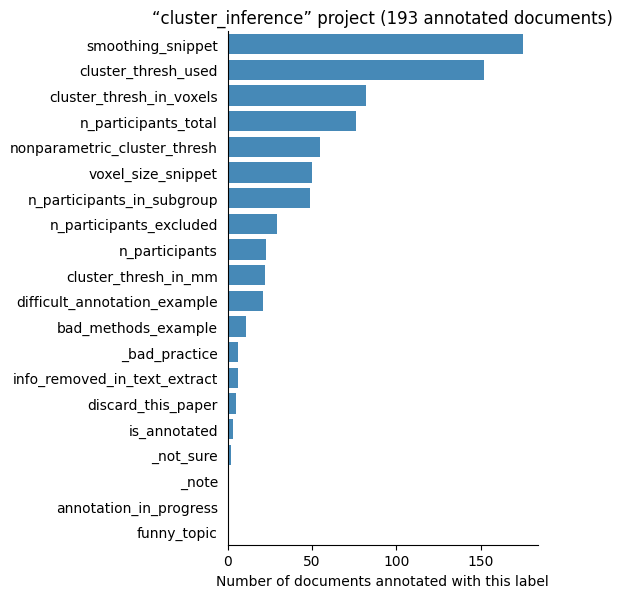

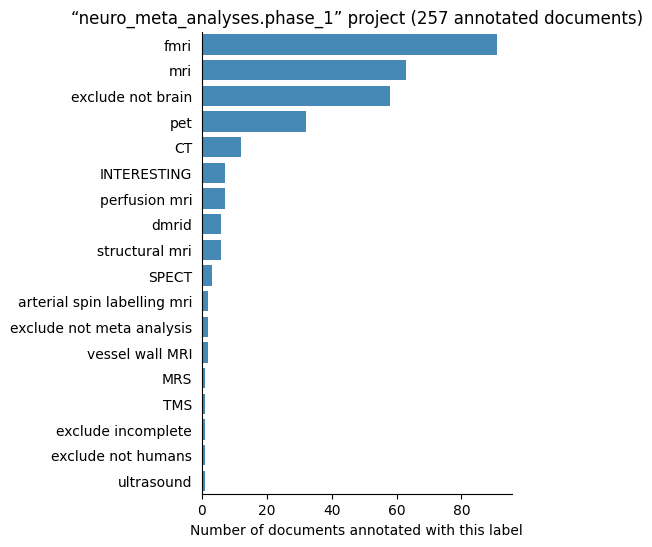

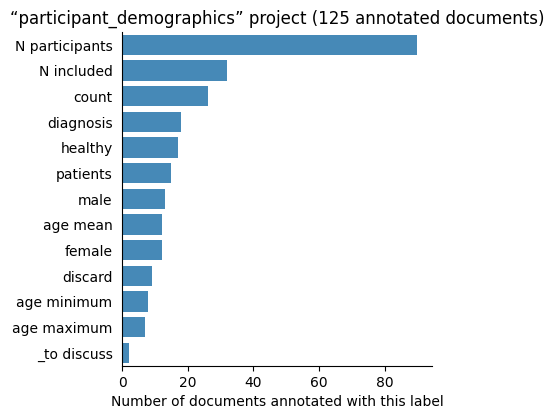

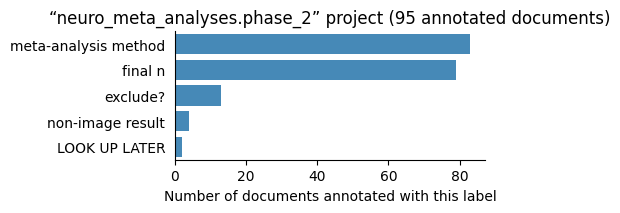

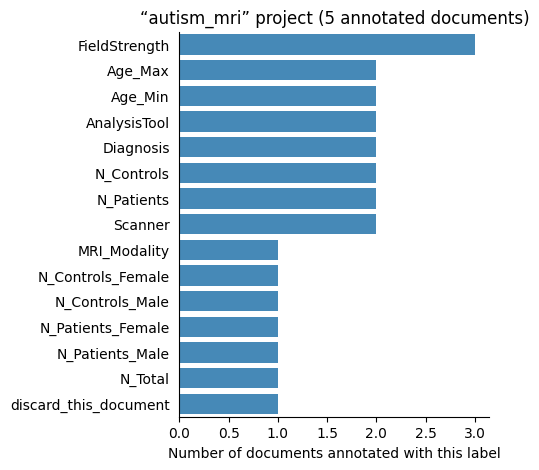

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

projects = label_counts.groupby("project_name", sort=False)

for project_name, data in projects:
    fig, ax = plt.subplots(figsize=(4, data.shape[0] / 3))
    sns.barplot(
        data=data, x="n_docs", y="label_name", ax=ax, color="#0071BC", alpha=.8
    )
    ax.yaxis.set_tick_params(left=False)
    ax.set_title(
        f'“{project_name}” project ({project_counts[project_name]} annotated documents)'
    )
    ax.set_ylabel("")
    ax.set_xlabel("Number of documents annotated with this label")
    sns.despine()